In [111]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.constraints import max_norm

import numpy as np
import os
import random
import matplotlib.pyplot as plt

import importlib
import utils.ml_utils as ml_utils
importlib.reload(ml_utils)

<module 'utils.ml_utils' from '/home/apurvapathak/ml-experiments/utils/ml_utils.py'>

## Set random seeds and make TF operation on GPU deterministic

In [2]:
# Make GPU use deterministic algorithms (see https://github.com/NVIDIA/tensorflow-determinism)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Seed value (can actually be different for each attribution step)
seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

## Load data

In [3]:
# Constants
IMG_SIZE = 128 # All images in the dataset will be resized to this size
BATCH_SIZE = 32 # Batch size

In [4]:
# Model State
model_state_by_type = {} # key: Model type, value: model_state

In [5]:
# Read training data
train, validation = ml_utils.load_batched_and_resized_dataset(
    dataset_name='cats_and_dogs',
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE
)

Training Data Summary
No. of examples: 18610
Class: 0 :::: Count: 9378 :::: Percentage: 50.39226222461043
Class: 1 :::: Count: 9232 :::: Percentage: 49.60773777538957

Validation Data Summary
No. of examples: 4652
Class: 0 :::: Count: 2280 :::: Percentage: 49.011177987962164
Class: 1 :::: Count: 2372 :::: Percentage: 50.988822012037836


## Base run

In [14]:
model = ml_utils.build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 4)       112       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 4)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 8)         296       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 32)       

In [15]:
# Start training
model_state_by_type['no_dropout'] = ml_utils.train_model(model, train, validation, epochs=30)

Epoch 1/30
582/582 [==============================] - 15s 26ms/step - loss: 0.6919 - accuracy: 0.5435 - val_loss: 0.6902 - val_accuracy: 0.5969
Epoch 2/30
582/582 [==============================] - 13s 23ms/step - loss: 0.6876 - accuracy: 0.5814 - val_loss: 0.6833 - val_accuracy: 0.6172
Epoch 3/30
582/582 [==============================] - 13s 23ms/step - loss: 0.6780 - accuracy: 0.5912 - val_loss: 0.6652 - val_accuracy: 0.6258
Epoch 4/30
582/582 [==============================] - 13s 23ms/step - loss: 0.6653 - accuracy: 0.6035 - val_loss: 0.6481 - val_accuracy: 0.6371
Epoch 5/30
582/582 [==============================] - 13s 23ms/step - loss: 0.6532 - accuracy: 0.6171 - val_loss: 0.6350 - val_accuracy: 0.6472
Epoch 6/30
582/582 [==============================] - 13s 23ms/step - loss: 0.6402 - accuracy: 0.6359 - val_loss: 0.6225 - val_accuracy: 0.6565
Epoch 7/30
582/582 [==============================] - 13s 23ms/step - loss: 0.6249 - accuracy: 0.6519 - val_loss: 0.6064 - val_accuracy:

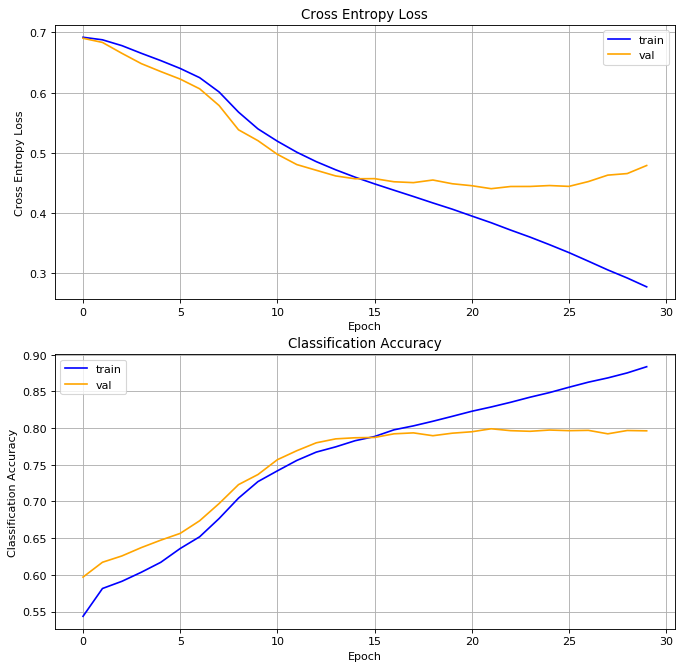

In [112]:
# Plot diagnostic learning curves
ml_utils.summarize_diagnostics(model_state_by_type['no_dropout'].history)

## Model with dropout

In [83]:
def build_model_with_dropout(
    dropout_rate=0.2,
    optimizer=keras.optimizers.SGD(learning_rate=0.1),
    initializer=keras.initializers.glorot_uniform(seed=0),
    seed_value=0
):
    """
    Builds a base model according to the parameters specified. Architecture is similar to VGG16.
    :param optimizer: Type of optimizer to use, along with corresponding optimizer settings
    :param initializer: Kernel initializer to use for each layer
    :return: Compiled Keras model
    """
    model = keras.models.Sequential([
        layers.Conv2D(
            input_shape=(IMG_SIZE,IMG_SIZE,3),
            filters=4,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu',
            kernel_initializer=initializer,
        ),
        layers.MaxPooling2D(),
        layers.Dropout(
            rate=dropout_rate,
            seed=seed_value
        ),
        layers.Conv2D(
            filters=8,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu',
            kernel_initializer=initializer
        ),
        layers.MaxPooling2D(),
        layers.Dropout(
            rate=dropout_rate,
            seed=seed_value
        ),
        layers.Conv2D(
            filters=16,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu',
            kernel_initializer=initializer
        ),
        layers.MaxPooling2D(),
        layers.Dropout(
            rate=dropout_rate,
            seed=seed_value
        ),
        layers.Conv2D(
            filters=32,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu',
            kernel_initializer=initializer
        ),
        layers.MaxPooling2D(),
        layers.Dropout(
            rate=dropout_rate,
            seed=seed_value
        ),
        layers.Conv2D(
            filters=64,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu',
            kernel_initializer=initializer
        ),
        layers.MaxPooling2D(),
        layers.Dropout(
            rate=dropout_rate,
            seed=seed_value
        ),
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_initializer=initializer),
        layers.Dropout(
            rate=dropout_rate,
            seed=seed_value
        ),
        layers.Dense(256, activation='relu', kernel_initializer=initializer),
        layers.Dense(1, activation='sigmoid', kernel_initializer=initializer),
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

## Try Different Dropout rates

In [85]:
dropout_rates = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

for dropout_rate in dropout_rates:
    print('Training with dropout rate: {rate}\n'.format(rate=dropout_rate))
    # Build and train model
    model = build_model_with_dropout(dropout_rate=dropout_rate)
    model_state_by_type['dropout_{rate}'.format(rate=dropout_rate)] = ml_utils.train_model(
        model=model, 
        train=train, 
        validation=validation, 
        epochs=30)

Training with dropout rate: 0

Epoch 1/30
582/582 [==============================] - 14s 24ms/step - loss: 0.6861 - accuracy: 0.5459 - val_loss: 0.6545 - val_accuracy: 0.6462
Epoch 2/30
582/582 [==============================] - 13s 22ms/step - loss: 0.6301 - accuracy: 0.6471 - val_loss: 0.5605 - val_accuracy: 0.7298
Epoch 3/30
582/582 [==============================] - 13s 21ms/step - loss: 0.5433 - accuracy: 0.7220 - val_loss: 0.5323 - val_accuracy: 0.7274
Epoch 4/30
582/582 [==============================] - 13s 22ms/step - loss: 0.4873 - accuracy: 0.7622 - val_loss: 0.4743 - val_accuracy: 0.7704
Epoch 5/30
582/582 [==============================] - 13s 22ms/step - loss: 0.4471 - accuracy: 0.7900 - val_loss: 0.4474 - val_accuracy: 0.7917
Epoch 6/30
582/582 [==============================] - 13s 22ms/step - loss: 0.4078 - accuracy: 0.8116 - val_loss: 0.4547 - val_accuracy: 0.7812
Epoch 7/30
582/582 [==============================] - 13s 22ms/step - loss: 0.3766 - accuracy: 0.8262 - v

582/582 [==============================] - 13s 22ms/step - loss: 0.2762 - accuracy: 0.8808 - val_loss: 0.4213 - val_accuracy: 0.8057
Epoch 28/30
582/582 [==============================] - 13s 22ms/step - loss: 0.2690 - accuracy: 0.8863 - val_loss: 0.4126 - val_accuracy: 0.8162
Epoch 29/30
582/582 [==============================] - 13s 22ms/step - loss: 0.2587 - accuracy: 0.8880 - val_loss: 0.4038 - val_accuracy: 0.8325
Epoch 30/30
582/582 [==============================] - 13s 22ms/step - loss: 0.2551 - accuracy: 0.8905 - val_loss: 0.4088 - val_accuracy: 0.8169
Training with dropout rate: 0.2

Epoch 1/30
582/582 [==============================] - 15s 25ms/step - loss: 0.6899 - accuracy: 0.5304 - val_loss: 0.6921 - val_accuracy: 0.5095
Epoch 2/30
582/582 [==============================] - 13s 22ms/step - loss: 0.6640 - accuracy: 0.6028 - val_loss: 0.6459 - val_accuracy: 0.6292
Epoch 3/30
582/582 [==============================] - 13s 22ms/step - loss: 0.6322 - accuracy: 0.6511 - val_los

582/582 [==============================] - 13s 22ms/step - loss: 0.4697 - accuracy: 0.7764 - val_loss: 0.4998 - val_accuracy: 0.7511
Epoch 24/30
582/582 [==============================] - 13s 22ms/step - loss: 0.4711 - accuracy: 0.7706 - val_loss: 0.4751 - val_accuracy: 0.7747
Epoch 25/30
582/582 [==============================] - 13s 22ms/step - loss: 0.4661 - accuracy: 0.7783 - val_loss: 0.4791 - val_accuracy: 0.7736
Epoch 26/30
582/582 [==============================] - 13s 22ms/step - loss: 0.4605 - accuracy: 0.7780 - val_loss: 0.4634 - val_accuracy: 0.7842
Epoch 27/30
582/582 [==============================] - 13s 22ms/step - loss: 0.4564 - accuracy: 0.7808 - val_loss: 0.4712 - val_accuracy: 0.7741
Epoch 28/30
582/582 [==============================] - 13s 23ms/step - loss: 0.4549 - accuracy: 0.7854 - val_loss: 0.4749 - val_accuracy: 0.7837
Epoch 29/30
582/582 [==============================] - 13s 22ms/step - loss: 0.4534 - accuracy: 0.7833 - val_loss: 0.4906 - val_accuracy: 0.74

582/582 [==============================] - 13s 22ms/step - loss: 0.6106 - accuracy: 0.6730 - val_loss: 0.6837 - val_accuracy: 0.5617
Epoch 20/30
582/582 [==============================] - 13s 23ms/step - loss: 0.6098 - accuracy: 0.6728 - val_loss: 0.6896 - val_accuracy: 0.5748
Epoch 21/30
582/582 [==============================] - 13s 23ms/step - loss: 0.6083 - accuracy: 0.6707 - val_loss: 0.6771 - val_accuracy: 0.5875
Epoch 22/30
582/582 [==============================] - 13s 22ms/step - loss: 0.6043 - accuracy: 0.6779 - val_loss: 0.6639 - val_accuracy: 0.6245
Epoch 23/30
582/582 [==============================] - 13s 23ms/step - loss: 0.6061 - accuracy: 0.6751 - val_loss: 0.6708 - val_accuracy: 0.6116
Epoch 24/30
582/582 [==============================] - 13s 22ms/step - loss: 0.6029 - accuracy: 0.6782 - val_loss: 0.6821 - val_accuracy: 0.5810
Epoch 25/30
582/582 [==============================] - 13s 23ms/step - loss: 0.6044 - accuracy: 0.6752 - val_loss: 0.6818 - val_accuracy: 0.57

Epoch 1/30
582/582 [==============================] - 15s 25ms/step - loss: 0.6948 - accuracy: 0.4995 - val_loss: 0.6935 - val_accuracy: 0.4901
Epoch 2/30
582/582 [==============================] - 13s 22ms/step - loss: 0.6936 - accuracy: 0.4996 - val_loss: 0.6935 - val_accuracy: 0.4901
Epoch 3/30
582/582 [==============================] - 13s 22ms/step - loss: 0.6936 - accuracy: 0.4982 - val_loss: 0.6936 - val_accuracy: 0.4901
Epoch 4/30
582/582 [==============================] - 13s 22ms/step - loss: 0.6935 - accuracy: 0.5023 - val_loss: 0.6937 - val_accuracy: 0.4901
Epoch 5/30
582/582 [==============================] - 13s 22ms/step - loss: 0.6936 - accuracy: 0.4987 - val_loss: 0.6936 - val_accuracy: 0.4901
Epoch 6/30
582/582 [==============================] - 13s 22ms/step - loss: 0.6935 - accuracy: 0.5010 - val_loss: 0.6936 - val_accuracy: 0.4901
Epoch 7/30
582/582 [==============================] - 13s 22ms/step - loss: 0.6935 - accuracy: 0.4984 - val_loss: 0.6936 - val_accuracy:

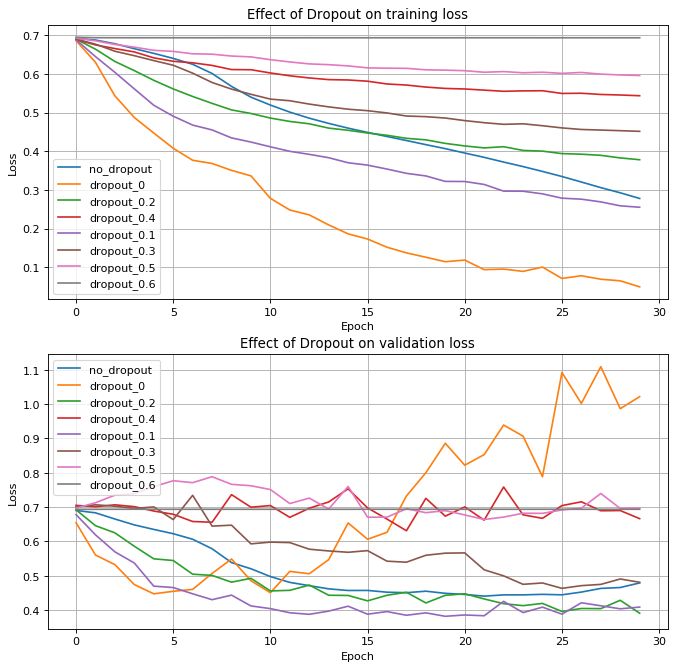

<Figure size 432x288 with 0 Axes>

In [103]:
ml_utils.plot_loss_by_param(model_state_by_type, 'Dropout', 'dropout_loss.png')

## Save & Load Model State

In [118]:
ml_utils.save_model_state(model_state_by_type, 'dropouts')

In [119]:
## Load Model State
#model_state_by_type = ml_utils.load_model_state('dropout')